# *tf-GAN*

dataset: http://vis-www.cs.umass.edu/lfw/

In [1]:
# need for imread, imresize
# pip install scipy==1.1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.keras import layers as L

#from util import fetch_lfw_dataset as load_data


plt.rcParams.update({'axes.titlesize': 'small'})

In [63]:
import os
import numpy as np
import pandas as pd
from scipy.misc import imread, imresize


def fetch_lfw_dataset(
    attrs_name="lfw_attributes.txt",
    images_name="lfw-deepfunneled",
    raw_images_name="lfw",
    use_raw=False,
    dx=80,dy=80,
    dimx=45,dimy=45
):

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),f"lost some data when merging dataframes. Len df: {len(df)} Len attrs: {len(df_attrs)}"

    #image preprocessing
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(lambda img: img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: imresize(img,[dimx,dimy]))#\
                                 #.apply(lambda img: (img1 * 255).astype(np.uint8))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs


### 1. Load data

In [3]:
data, attrs = load_data(dimx=36,dimy=36)

In [10]:
# # Normalize inputs
# data = (np.float32(data)) / 255.

# IMG_SHAPE = data.shape[1:]

# plt.imshow(data[0].clip(0,1))

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [15]:
train_images = (data - 127.5) / 127.5 # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:

# #from tensorflow.keras.layers.advanced_activations import *

# s = K.get_session()

In [32]:
#generator.add(L.Dropout(rate=0.4))

CODE_SIZE = 256

generator = tf.keras.Sequential()

generator.add(L.InputLayer([CODE_SIZE], name='noise'))

generator.add(L.Dense(10*8*8, activation='elu'))
generator.add(L.Reshape((8,8,10)))

generator.add(L.Conv2DTranspose(64, kernel_size=(5,5), activation='elu'))
generator.add(L.Conv2DTranspose(64, kernel_size=(5,5), activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))

generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))
generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))
generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))

generator.add(L.Conv2D(3, kernel_size=3, activation='tanh'))

In [33]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s" % (IMG_SHAPE,generator.output_shape[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [34]:
#discriminator.add(LeakyReLU(0.3))

discriminator = tf.keras.Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE, name='image'))

discriminator.add(L.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
discriminator.add(L.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
discriminator.add(L.Dropout(rate=0.25))

discriminator.add(L.AveragePooling2D(pool_size=(2,2)))

discriminator.add(L.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
discriminator.add(L.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
discriminator.add(L.AveragePooling2D(pool_size=(2,2)))
discriminator.add(L.Dropout(rate=0.25))

discriminator.add(L.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
discriminator.add(L.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
discriminator.add(L.AveragePooling2D(pool_size=(2,2)))
discriminator.add(L.Dropout(rate=0.25))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(CODE_SIZE, activation='relu'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

# Training


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [35]:
[None,] + list(IMG_SHAPE)

[None, 36, 36, 3]

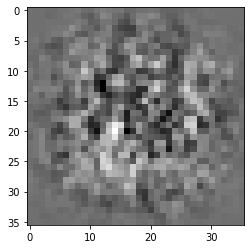

In [39]:
noise = tf.random.normal(shape=[1,CODE_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [64]:
from keras import Input

noise = Input(dtype='float32', shape=[CODE_SIZE])
real_data = Input(dtype='float32', shape=list(IMG_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)

In [40]:
decision = discriminator(generated_image)

In [45]:
# ########################
# #discriminator training#
# ########################

# def foo():
#     return tf.math.reduce_mean(logp_real[:,1] + logp_gen[:,0])
    
    
# # d_loss = -tf.compat.v1.reduce_mean(logp_real[:,1] + logp_gen[:,0])

# # #regularize
# # d_loss += tf.compat.v1.reduce_mean(discriminator.layers[-1].kernel**2)

# #optimize
# disc_optimizer = tf.optimizers.SGD(1e-3).minimize(foo, var_list=discriminator.trainable_weights)

In [44]:
# ########################
# ###generator training###
# ########################

# #gen loss
# g_loss = tf.reduce_mean(logp_gen[:,0])

# #optimize
# gen_optimizer = tf.keras.optimizers.Adam(1e-4).minimize(g_loss, var_list=generator.trainable_weights)

In [61]:
import os 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50
noise_dim = CODE_SIZE
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)


In [62]:
import time
train(train_dataset, EPOCHS)


KeyboardInterrupt: 

### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [ ]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow, ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        #images = images.clip(np.min(data), np.max(data))
        images = images.clip(0,1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

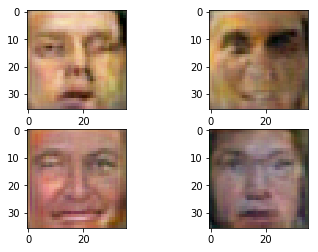

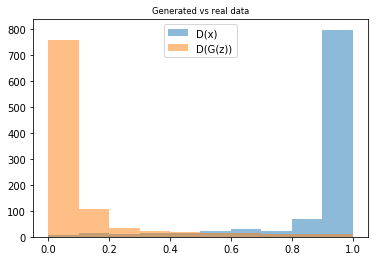

26700
Buffered data was truncated after reaching the output size limit.

In [ ]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    
    feed_dict = {
        real_data:sample_data_batch(50),
        noise:sample_noise_batch(50)
    } 
    
    for i in range(5):
        s.run(disc_optimizer,feed_dict)
    
    s.run(gen_optimizer,feed_dict)
    
    if epoch % 100==0:
        display.clear_output(wait=True)
        sample_images(2,2,True)
        sample_probas(1000)
        print(epoch)
        

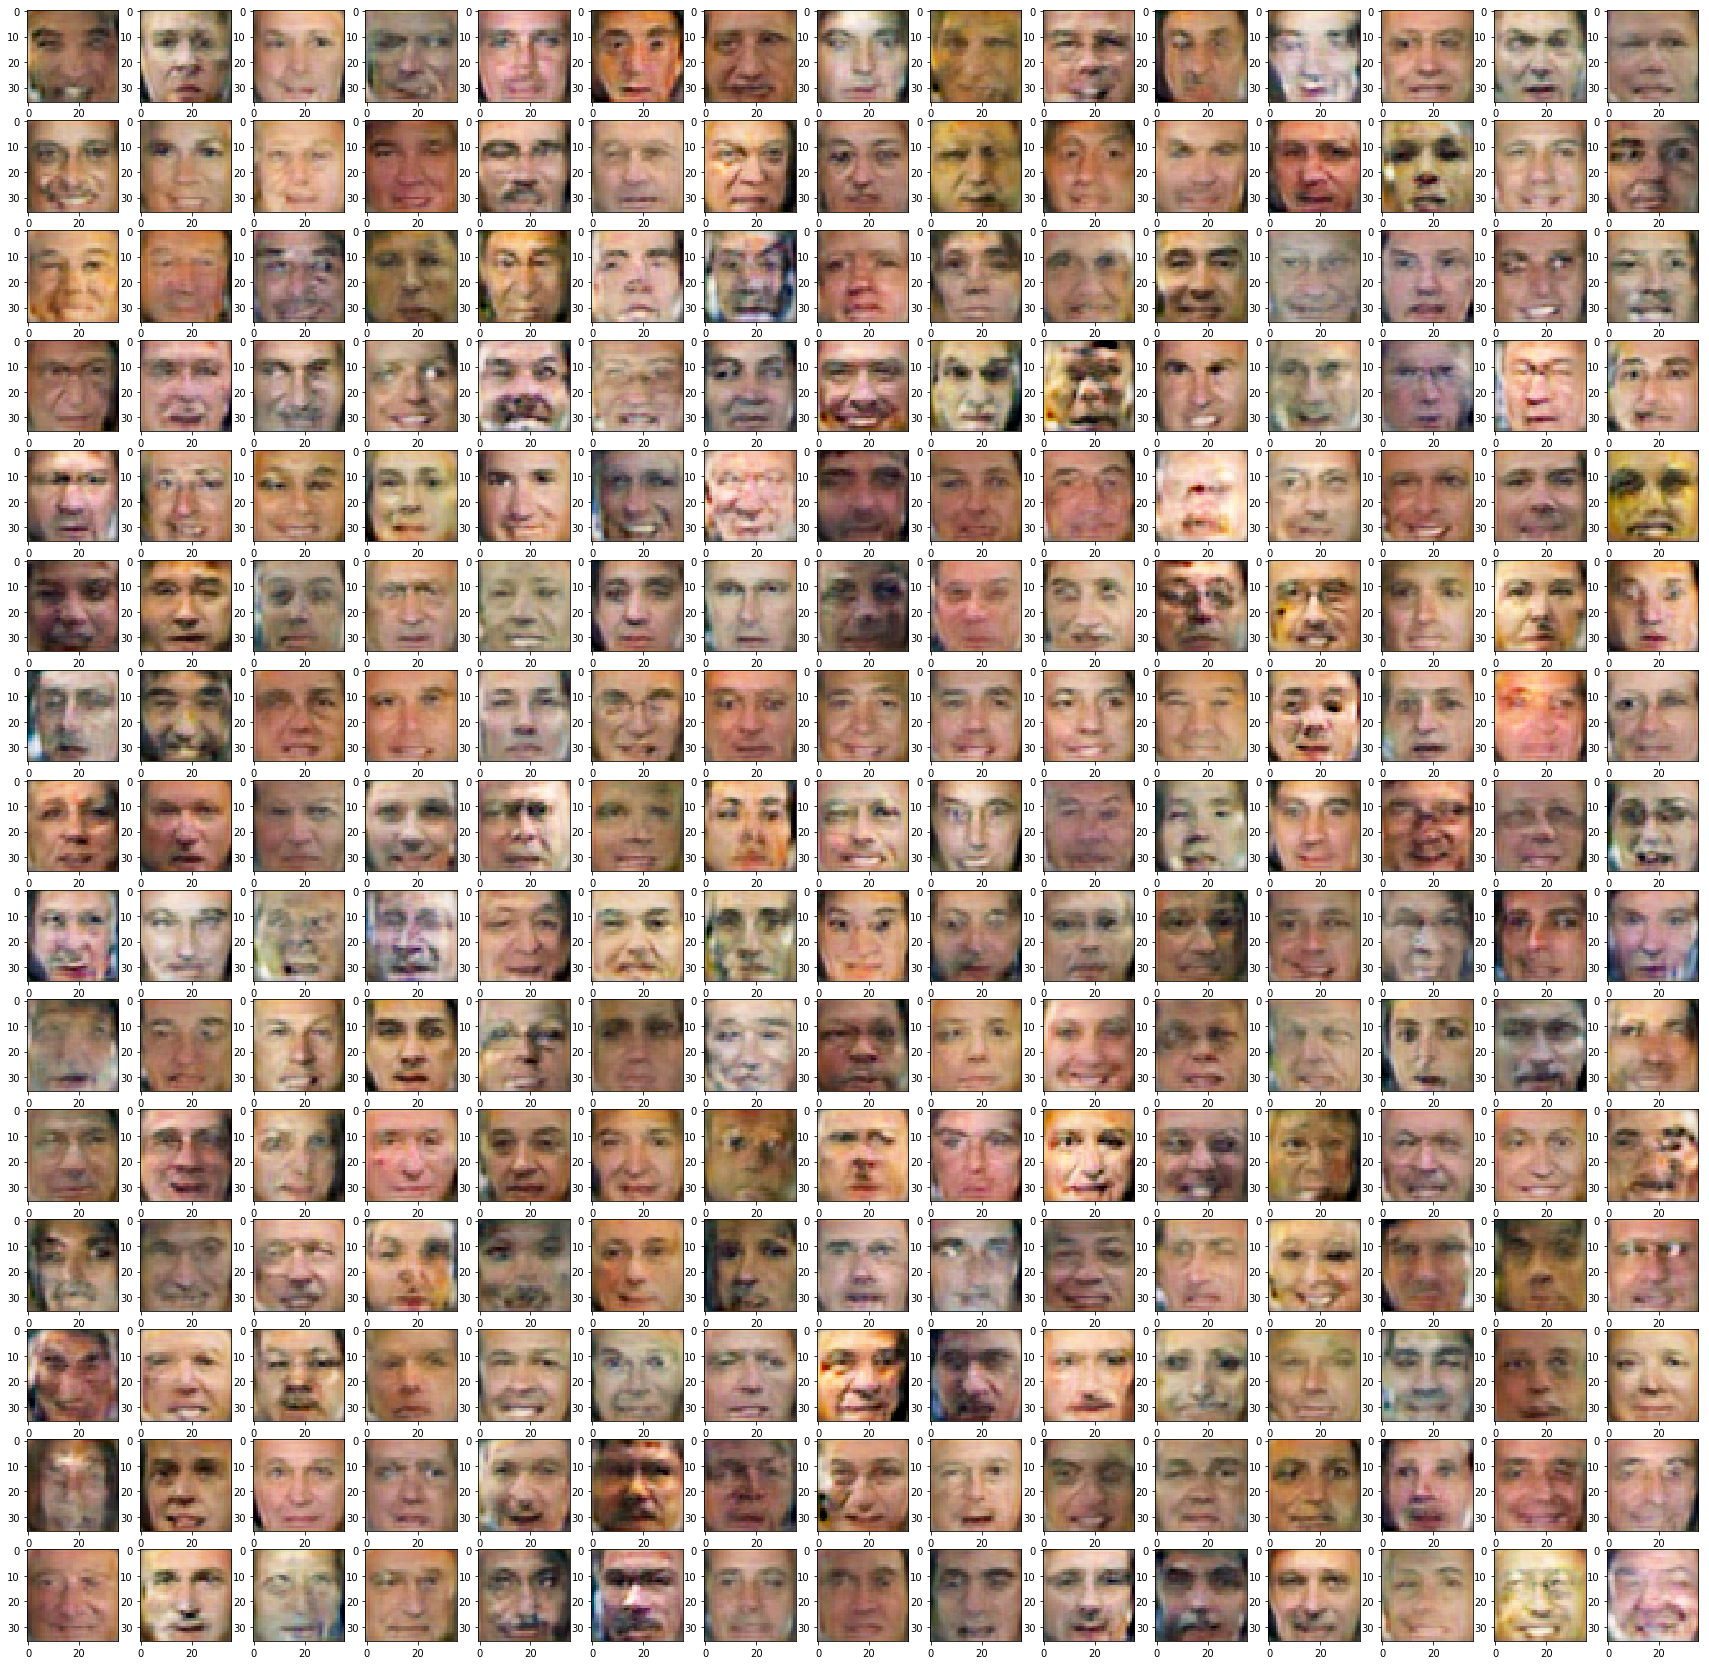

In [ ]:
#The network was trained for about 50k iterations. 
#Training for longer yields MUCH better results
plt.figure(figsize=[30,30])
sample_images(15,15)